In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [17]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=False
)

print("MNIST loaded: ", len(train_set), "training samples,", len(test_set), "test samples")


MNIST loaded:  60000 training samples, 10000 test samples


In [18]:
class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, epsilon):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.epsilon = epsilon

        self.weight = nn.Parameter(torch.zeros(out_features, in_features))
        self.mask = torch.zeros_like(self.weight)

        self.reset_parameters()

    def reset_parameters(self):
        # Erdős–Rényi sparse initialization
        prob = self.epsilon * (self.in_features + self.out_features) / (self.in_features * self.out_features)
        mask = torch.rand_like(self.weight) < prob
        self.mask = mask.float()
        self.weight.data = torch.randn_like(self.weight) * 0.1 * self.mask

    def forward(self, x):
        return F.linear(x, self.weight * self.mask)



In [19]:
class SETModel(nn.Module):
    def __init__(self, epsilon):
        super().__init__()
        self.fc1 = SparseLinear(784, 300, epsilon)
        self.fc2 = SparseLinear(300, 100, epsilon)
        self.fc3 = nn.Linear(100, 10)  # Final dense output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten 28x28 image to 784-dim vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
def evolve_layer(layer, zeta):
    weight = layer.weight.data
    mask = layer.mask

    # Step 1: Get magnitude of active weights only
    scores = torch.abs(weight * mask)

    # Step 2: Compute pruning threshold (zeta = % to prune)
    threshold = torch.quantile(scores[scores != 0], zeta)

    # Step 3: Prune connections below threshold
    prune_mask = (scores <= threshold).float()
    keep_mask = (scores > threshold).float()

    # Step 4: Regrow new random connections where pruned
    new_connections = (torch.rand_like(mask) < prune_mask).float()

    # Final mask: keep existing + regrow - overlap
    layer.mask = keep_mask + new_connections - (keep_mask * new_connections)
    layer.weight.data *= layer.mask


In [21]:
def train(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


In [22]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [23]:
epsilon = 20   # Controls initial sparsity
zeta = 0.3     # % of weights to prune each epoch
epochs = 20    # You can reduce to 10 if testing

model = SETModel(epsilon).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accs, test_accs = [], []

for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader)

    # Sparse rewiring (evolution)
    evolve_layer(model.fc1, zeta)
    evolve_layer(model.fc2, zeta)

    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} → Loss: {loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch 1/20 → Loss: 0.6085 | Train Acc: 92.45% | Test Acc: 92.56%
Epoch 2/20 → Loss: 0.1670 | Train Acc: 97.52% | Test Acc: 96.85%
Epoch 3/20 → Loss: 0.0763 | Train Acc: 98.33% | Test Acc: 97.37%
Epoch 4/20 → Loss: 0.0519 | Train Acc: 98.68% | Test Acc: 97.70%
Epoch 5/20 → Loss: 0.0361 | Train Acc: 99.31% | Test Acc: 98.07%
Epoch 6/20 → Loss: 0.0269 | Train Acc: 99.46% | Test Acc: 98.14%
Epoch 7/20 → Loss: 0.0193 | Train Acc: 99.47% | Test Acc: 97.94%
Epoch 8/20 → Loss: 0.0175 | Train Acc: 99.64% | Test Acc: 98.31%
Epoch 9/20 → Loss: 0.0162 | Train Acc: 99.66% | Test Acc: 97.98%
Epoch 10/20 → Loss: 0.0144 | Train Acc: 99.55% | Test Acc: 97.91%
Epoch 11/20 → Loss: 0.0105 | Train Acc: 99.56% | Test Acc: 98.01%
Epoch 12/20 → Loss: 0.0086 | Train Acc: 99.61% | Test Acc: 98.03%
Epoch 13/20 → Loss: 0.0114 | Train Acc: 99.83% | Test Acc: 98.13%
Epoch 14/20 → Loss: 0.0077 | Train Acc: 99.73% | Test Acc: 98.10%
Epoch 15/20 → Loss: 0.0062 | Train Acc: 99.91% | Test Acc: 98.26%
Epoch 16/20 → Loss:

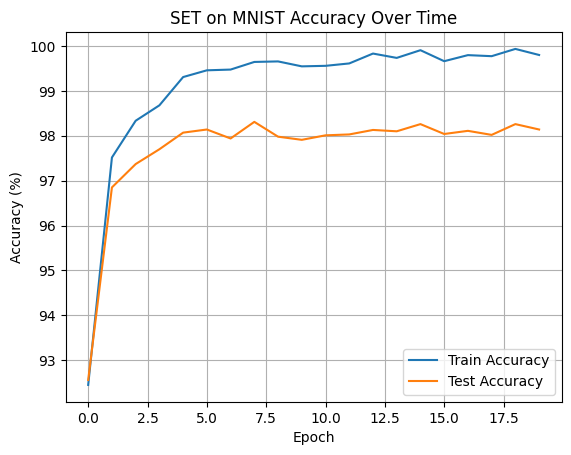

In [24]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('SET on MNIST Accuracy Over Time')
plt.grid(True)
plt.legend()
plt.show()
